## Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
#!pip install imblearn
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, plot_roc_curve, f1_score, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import data files

In [2]:
clean_data = pd.read_csv('../assets/combined1.csv')

In [3]:
clean_data.head()

,nummosquitos,wnvpresent,year,month,latitude,longitude,week,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,...,avgspeed3,rel_humidity3,VCTS_week3,FG_week3,TSRA_week3,RA_week3,DZ_week3,BR_week3,HZ_week3,preciptotal_sum3
0,0,0,2007,5,41.688324,-87.676709,22,0,1,0,...,8.357143,51.630993,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.025
1,0,0,2007,5,41.688324,-87.676709,22,0,0,1,...,8.357143,51.630993,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.025
2,0,0,2007,5,41.720848,-87.666014,22,0,0,1,...,8.357143,51.630993,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.025
3,0,0,2007,5,41.731922,-87.677512,22,1,0,0,...,8.357143,51.630993,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.025
4,0,0,2007,5,41.731922,-87.677512,22,0,0,1,...,8.357143,51.630993,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.025


### Pre-modelling checks

Drop unnecessary columns.\
Unnecessary columns were determined through few different ways.\
One could be from a model such as logistic regression where regularization is carried out and some variables would be removed through L1 regularization.\
Another would be through the correlation plot where variables with multicolinearity are streamlined.\
Also, some such as dummy variables were simply through a process of iteration, where a better model performance was discovered when these variables were dropped.

In [4]:
clean_data.drop(columns = ['species_CULEX PIPIENS', 'species_CULEX PIPIENS/RESTUANS', 'species_UNSPECIFIED CULEX' , 
                           'species_CULEX RESTUANS', 'species_CULEX SALINARIUS', 'species_CULEX TARSALIS',
                           'species_CULEX TERRITANS', 'station', 'stnpressure', 'resultdir', 'VCTS_week',
                          'FG_week', 'TSRA_week', 'RA_week', 'DZ_week', 'BR_week', 'HZ_week', 'VCTS_week2',
                          'FG_week2', 'TSRA_week2', 'RA_week2', 'DZ_week2', 'BR_week2', 'HZ_week2', 'VCTS_week3',
                          'FG_week3', 'TSRA_week3', 'RA_week3', 'DZ_week3', 'BR_week3', 'HZ_week3',
                          'stnpressure2', 'stnpressure3', 'resultdir2', 'resultdir3',
                          'tavg', 'tavg2', 'tavg3', 'dewpoint', 'dewpoint2', 'dewpoint3', 
                          'month', 'long_lat', 'cool', 'wetbulb2', 'preciptotal2',
                          'preciptotal_sum2', 'rel_humidity3'], inplace=True)

Confirm no null values

In [5]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7732 entries, 0 to 7731
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   nummosquitos      7732 non-null   int64  
 1   wnvpresent        7732 non-null   int64  
 2   year              7732 non-null   int64  
 3   latitude          7732 non-null   float64
 4   longitude         7732 non-null   float64
 5   week              7732 non-null   int64  
 6   wetbulb           7732 non-null   float64
 7   heat              7732 non-null   float64
 8   preciptotal       7732 non-null   float64
 9   avgspeed          7732 non-null   float64
 10  rel_humidity      7732 non-null   float64
 11  preciptotal_sum   7732 non-null   float64
 12  heat2             7732 non-null   float64
 13  cool2             7732 non-null   float64
 14  avgspeed2         7732 non-null   float64
 15  rel_humidity2     7732 non-null   float64
 16  wetbulb3          7732 non-null   float64


Check for class imbalances

In [6]:
clean_data['wnvpresent'].value_counts()

0    7288
1     444
Name: wnvpresent, dtype: int64

Class imbalances in percent

In [7]:
clean_data['wnvpresent'].value_counts(normalize=True)

0    0.942576
1    0.057424
Name: wnvpresent, dtype: float64

Merge some data, simply leveraging on nummosquitos to condense the same traps for the same date together and not using the nummosquitos data.

In [8]:
clean_data

,nummosquitos,wnvpresent,year,latitude,longitude,week,wetbulb,heat,preciptotal,avgspeed,...,heat2,cool2,avgspeed2,rel_humidity2,wetbulb3,heat3,cool3,preciptotal3,avgspeed3,preciptotal_sum3
0,0,0,2007,41.688324,-87.676709,22,64.714286,0.000000,0.152143,7.585714,...,5.428571,2.000000,10.857143,47.283352,54.714286,3.0,2.571429,0.003571,8.357143,0.025
1,0,0,2007,41.688324,-87.676709,22,64.714286,0.000000,0.152143,7.585714,...,5.428571,2.000000,10.857143,47.283352,54.714286,3.0,2.571429,0.003571,8.357143,0.025
2,0,0,2007,41.720848,-87.666014,22,64.714286,0.000000,0.152143,7.585714,...,5.428571,2.000000,10.857143,47.283352,54.714286,3.0,2.571429,0.003571,8.357143,0.025
3,0,0,2007,41.731922,-87.677512,22,64.714286,0.000000,0.152143,7.585714,...,5.428571,2.000000,10.857143,47.283352,54.714286,3.0,2.571429,0.003571,8.357143,0.025
4,0,0,2007,41.731922,-87.677512,22,64.714286,0.000000,0.152143,7.585714,...,5.428571,2.000000,10.857143,47.283352,54.714286,3.0,2.571429,0.003571,8.357143,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7727,0,0,2013,41.987280,-87.666066,39,56.285714,3.428571,0.054286,7.385714,...,2.285714,8.857143,8.900000,60.854538,63.857143,0.0,6.285714,0.002143,8.000000,0.015
7728,0,0,2013,41.991429,-87.747113,39,56.285714,3.428571,0.054286,7.385714,...,2.285714,8.857143,8.900000,60.854538,63.857143,0.0,6.285714,0.002143,8.000000,0.015
7729,0,0,2013,41.992478,-87.862995,39,56.285714,3.428571,0.054286,7.385714,...,2.285714,8.857143,8.900000,60.854538,63.857143,0.0,6.285714,0.002143,8.000000,0.015
7730,0,0,2013,42.008314,-87.777921,39,56.285714,3.428571,0.054286,7.385714,...,2.285714,8.857143,8.900000,60.854538,63.857143,0.0,6.285714,0.002143,8.000000,0.015


In [9]:
clean_data1 = clean_data.groupby([ 'year', 'week', 'wnvpresent', 'longitude']).mean()
clean_data1

nummosquitos   latitude    wetbulb      heat  \
year week wnvpresent longitude                                                  
2007 22   0          -87.824812             0  41.974089  63.857143  0.000000   
                     -87.800991             0  41.954690  63.857143  0.000000   
                     -87.795585             0  41.999129  63.857143  0.000000   
                     -87.769279             0  41.994991  63.857143  0.000000   
                     -87.760886             0  41.907645  64.714286  0.000000   
...                                       ...        ...        ...       ...   
2013 39   0          -87.535198             0  41.680946  56.000000  2.142857   
          1          -87.890615             1  41.974689  56.285714  3.428571   
                     -87.778927             1  41.776156  56.000000  2.142857   
                     -87.757639             1  41.964242  56.285714  3.428571   
                     -87.742302             1  41.763733  56.000000  2.142857   

                                 preciptotal  avgspeed  rel_humidity  \
year week wnvpresent longitude                                         
2007 22   0          -87.824812     0.036429  7.542857     62.824094   
                     -87.800991     0.036429  7.542857     62.824094   
                     -87.795585     0.036429  7.542857     62.824094   
                     -87.769279     0.036429  7.542857     62.824094   
                     -87.760886     0.152143  7.585714     59.072509   
...                                      ...       ...           ...   
2013 39   0          -87.535198     0.034286  7.557143     58.523131   
          1          -87.890615     0.054286  7.385714     66.104488   
                     -87.778927     0.034286  7.557143     58.523131   
                     -87.757639     0.054286  7.385714     66.104488   
                     -87.742302     0.034286  7.557143     58.523131   

                                 preciptotal_sum     heat2     cool2  \
year week wnvpresent longitude                                         
2007 22   0          -87.824812            0.255  5.571429  2.142857   
                     -87.800991            0.255  5.571429  2.142857   
                     -87.795585            0.255  5.571429  2.142857   
                     -87.769279            0.255  5.571429  2.142857   
                     -87.760886            1.065  5.428571  2.000000   
...                                          ...       ...       ...   
2013 39   0          -87.535198            0.240  1.714286  9.428571   
          1          -87.890615            0.380  2.285714  8.857143   
                     -87.778927            0.240  1.714286  9.428571   
                     -87.757639            0.380  2.285714  8.857143   
                     -87.742302            0.240  1.714286  9.428571   

                                 avgspeed2  rel_humidity2   wetbulb3  \
year week wnvpresent longitude                                         
2007 22   0          -87.824812  11.814286      48.001934  54.571429   
                     -87.800991  11.814286      48.001934  54.571429   
                     -87.795585  11.814286      48.001934  54.571429   
                     -87.769279  11.814286      48.001934  54.571429   
                     -87.760886  10.857143      47.283352  54.714286   
...                                    ...            ...        ...   
2013 39   0          -87.535198   9.042857      56.480949  63.428571   
          1          -87.890615   8.900000      60.854538  63.857143   
                     -87.778927   9.042857      56.480949  63.428571   
                     -87.757639   8.900000      60.854538  63.857143   
                     -87.742302   9.042857      56.480949  63.428571   

                                    heat3     cool3  preciptotal3  avgspeed3  \
year week wnvpresent longitude                                                 
2007 22 

In [10]:
clean_data1['year'] = clean_data1.index.get_level_values('year')
clean_data1['week'] = clean_data1.index.get_level_values('week')
clean_data1['wnvpresent'] = clean_data1.index.get_level_values('wnvpresent')
clean_data1['longitude'] = clean_data1.index.get_level_values('longitude')
clean_data1.reset_index(inplace=True, drop=True)
clean_data1

,nummosquitos,latitude,wetbulb,heat,preciptotal,avgspeed,rel_humidity,preciptotal_sum,heat2,cool2,...,wetbulb3,heat3,cool3,preciptotal3,avgspeed3,preciptotal_sum3,year,week,wnvpresent,longitude
0,0,41.974089,63.857143,0.000000,0.036429,7.542857,62.824094,0.255,5.571429,2.142857,...,54.571429,3.285714,1.714286,0.019286,8.642857,0.135,2007,22,0,-87.824812
1,0,41.954690,63.857143,0.000000,0.036429,7.542857,62.824094,0.255,5.571429,2.142857,...,54.571429,3.285714,1.714286,0.019286,8.642857,0.135,2007,22,0,-87.800991
2,0,41.999129,63.857143,0.000000,0.036429,7.542857,62.824094,0.255,5.571429,2.142857,...,54.571429,3.285714,1.714286,0.019286,8.642857,0.135,2007,22,0,-87.795585
3,0,41.994991,63.857143,0.000000,0.036429,7.542857,62.824094,0.255,5.571429,2.142857,...,54.571429,3.285714,1.714286,0.019286,8.642857,0.135,2007,22,0,-87.769279
4,0,41.907645,64.714286,0.000000,0.152143,7.585714,59.072509,1.065,5.428571,2.000000,...,54.714286,3.000000,2.571429,0.003571,8.357143,0.025,2007,22,0,-87.760886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,0,41.680946,56.000000,2.142857,0.034286,7.557143,58.523131,0.240,1.714286,9.428571,...,63.428571,0.000000,7.285714,0.000000,7.957143,0.000,2013,39,0,-87.535198
4316,1,41.974689,56.285714,3.428571,0.054286,7.385714,66.104488,0.380,2.285714,8.857143,...,63.857143,0.000000,6.285714,0.002143,8.000000,0.015,2013,39,1,-87.890615
4317,1,41.776156,56.000000,2.142857,0.034286,7.557143,58.523131,0.240,1.714286,9.428571,...,63.428571,0.000000,7.285714,0.000000,7.957143,0.000,2013,39,1,-87.778927
4318,1,41.964242,56.285714,3.428571,0.054286,7.385714,66.104488,0.380,2.285714,8.857143,...,63.857143,0.000000,6.285714,0.002143,8.000000,0.015,2013,39,1,-87.757639


In [11]:
# define function to shift columns
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [12]:
clean_data1 = movecol(clean_data1, cols_to_move=['week'], ref_col='latitude', place='Before')
clean_data1 = movecol(clean_data1, cols_to_move=['longitude'], ref_col='latitude', place='After')
clean_data1

,nummosquitos,week,latitude,longitude,wetbulb,heat,preciptotal,avgspeed,rel_humidity,preciptotal_sum,...,avgspeed2,rel_humidity2,wetbulb3,heat3,cool3,preciptotal3,avgspeed3,preciptotal_sum3,year,wnvpresent
0,0,22,41.974089,-87.824812,63.857143,0.000000,0.036429,7.542857,62.824094,0.255,...,11.814286,48.001934,54.571429,3.285714,1.714286,0.019286,8.642857,0.135,2007,0
1,0,22,41.954690,-87.800991,63.857143,0.000000,0.036429,7.542857,62.824094,0.255,...,11.814286,48.001934,54.571429,3.285714,1.714286,0.019286,8.642857,0.135,2007,0
2,0,22,41.999129,-87.795585,63.857143,0.000000,0.036429,7.542857,62.824094,0.255,...,11.814286,48.001934,54.571429,3.285714,1.714286,0.019286,8.642857,0.135,2007,0
3,0,22,41.994991,-87.769279,63.857143,0.000000,0.036429,7.542857,62.824094,0.255,...,11.814286,48.001934,54.571429,3.285714,1.714286,0.019286,8.642857,0.135,2007,0
4,0,22,41.907645,-87.760886,64.714286,0.000000,0.152143,7.585714,59.072509,1.065,...,10.857143,47.283352,54.714286,3.000000,2.571429,0.003571,8.357143,0.025,2007,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,0,39,41.680946,-87.535198,56.000000,2.142857,0.034286,7.557143,58.523131,0.240,...,9.042857,56.480949,63.428571,0.000000,7.285714,0.000000,7.957143,0.000,2013,0
4316,1,39,41.974689,-87.890615,56.285714,3.428571,0.054286,7.385714,66.104488,0.380,...,8.900000,60.854538,63.857143,0.000000,6.285714,0.002143,8.000000,0.015,2013,1
4317,1,39,41.776156,-87.778927,56.000000,2.142857,0.034286,7.557143,58.523131,0.240,...,9.042857,56.480949,63.428571,0.000000,7.285714,0.000000,7.957143,0.000,2013,1
4318,1,39,41.964242,-87.757639,56.285714,3.428571,0.054286,7.385714,66.104488,0.380,...,8.900000,60.854538,63.857143,0.000000,6.285714,0.002143,8.000000,0.015,2013,1


In [13]:
clean_data1.shape

(4320, 22)

In [14]:
clean_data1['wnvpresent'].value_counts()

0    3948
1     372
Name: wnvpresent, dtype: int64

In [15]:
clean_data1['wnvpresent'].value_counts(normalize=True)

0    0.913889
1    0.086111
Name: wnvpresent, dtype: float64

Last look on correlation to KIV any expected variables of interest

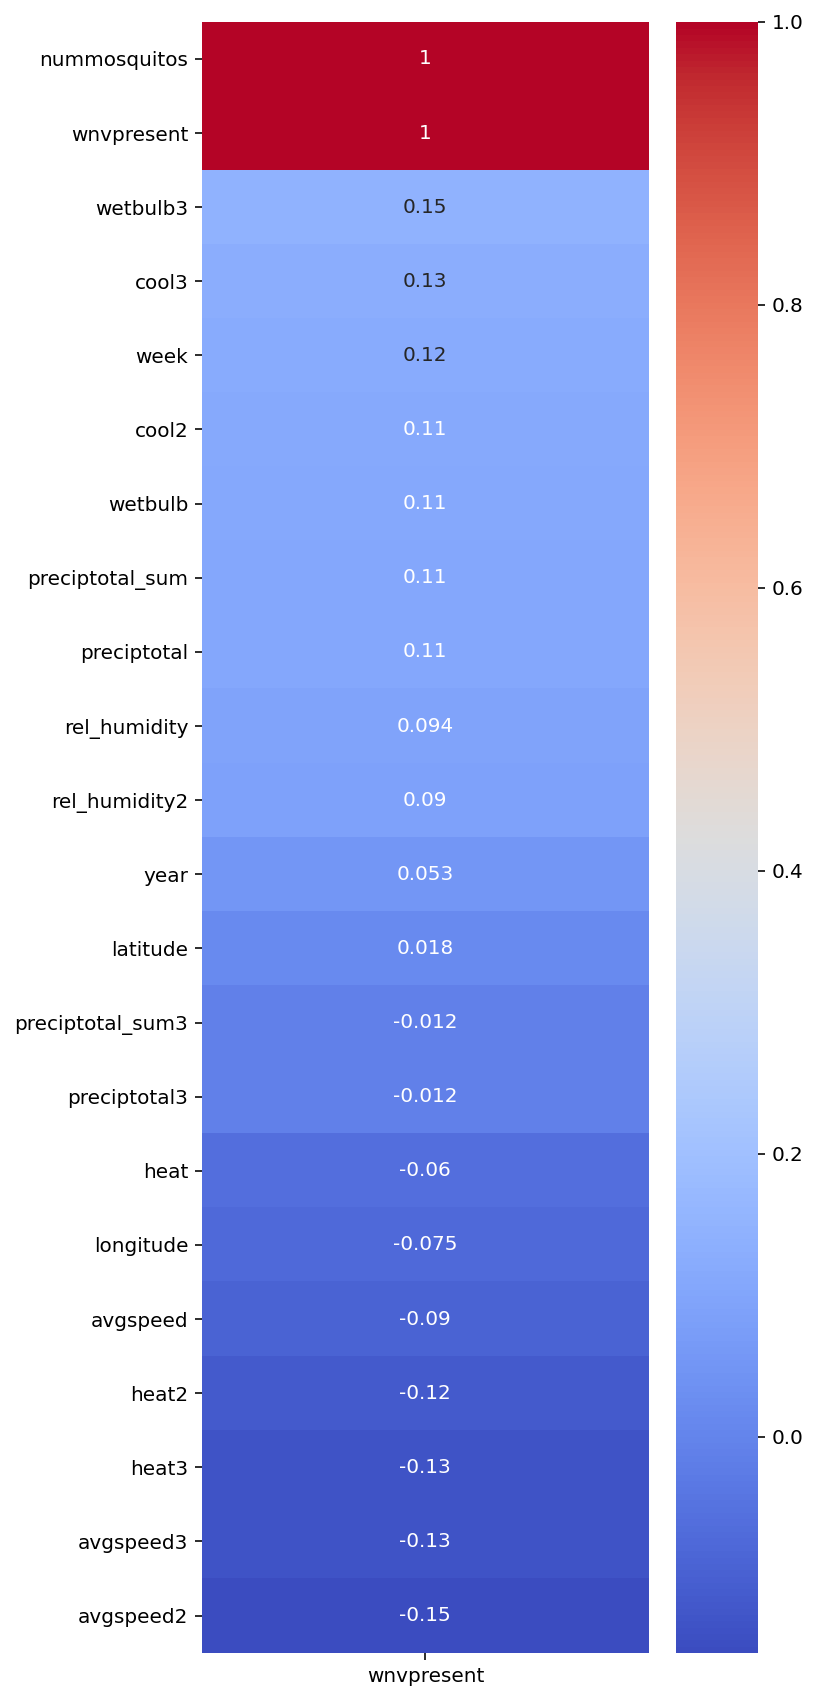

In [16]:
plt.figure(figsize=(5,15))
sns.heatmap(clean_data1.corr()[['wnvpresent']].sort_values(by='wnvpresent', ascending=False), 
            annot=True, cmap='coolwarm');

None of the features shows direct correlation with the presence of west nile virus.\
Part of the reason could be due to the imbalanced class with few datapoints for wnvpresent with only ~6% of data.

### Setting the X and y variables

In [17]:
y = clean_data1['wnvpresent']

In [18]:
X = clean_data1.drop(columns = ['wnvpresent', 'year', 'nummosquitos'])
X.head()

,week,latitude,longitude,wetbulb,heat,preciptotal,avgspeed,rel_humidity,preciptotal_sum,heat2,cool2,avgspeed2,rel_humidity2,wetbulb3,heat3,cool3,preciptotal3,avgspeed3,preciptotal_sum3
0,22,41.974089,-87.824812,63.857143,0.0,0.036429,7.542857,62.824094,0.255,5.571429,2.142857,11.814286,48.001934,54.571429,3.285714,1.714286,0.019286,8.642857,0.135
1,22,41.954690,-87.800991,63.857143,0.0,0.036429,7.542857,62.824094,0.255,5.571429,2.142857,11.814286,48.001934,54.571429,3.285714,1.714286,0.019286,8.642857,0.135
2,22,41.999129,-87.795585,63.857143,0.0,0.036429,7.542857,62.824094,0.255,5.571429,2.142857,11.814286,48.001934,54.571429,3.285714,1.714286,0.019286,8.642857,0.135
3,22,41.994991,-87.769279,63.857143,0.0,0.036429,7.542857,62.824094,0.255,5.571429,2.142857,11.814286,48.001934,54.571429,3.285714,1.714286,0.019286,8.642857,0.135
4,22,41.907645,-87.760886,64.714286,0.0,0.152143,7.585714,59.072509,1.065,5.428571,2.000000,10.857143,47.283352,54.714286,3.000000,2.571429,0.003571,8.357143,0.025


In [19]:
clean_data1.shape

(4320, 22)

### Train test split

Setting the random state as variable. This enables ease of changing the random state.

In [20]:
rs = 5

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs, stratify=y)

### Classification scores for pipeline model

In [22]:
# Note that this requires SKLearn version 1.0
def scores_pl(model, model_name):
    
    # derive tn, fp, tn, tp from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    
    # get roc auc score
    ras = roc_auc_score(y_test, model.predict(X_test))
    
    # print results
    print(f'Model : {model_name}')
    print(f'Best CV Recall score : {model.best_score_*100:.1f}%')
    print(f'Train Recall score : {model.score(X_train, y_train)*100:.1f}%')
    #print(f'Test score (accuracy) : {model.score(X_test, y_test)*100:.1f}%')
    print(f'Sensitivity/Recall (true positive rate) : {tp/(tp+fn)*100:.1f}%')
    #print(f'Specificity (true negative rate) : {tn/(tn+fp)*100:.1f}%')
    print(f'Precision (positive predictive rate) : {tp/(tp+fp)*100:.1f}%')
    print(f'Misclassification : {(1-((tp+tn)/(tp+tn+fp+fn)))*100:.1f}%')    
    print(f'F1-score : {2*tp/(2*tp+fp+fn)*100:.1f}%')
    print(f'roc_auc score : {ras*100:.1f}%')
    
    # plot confusion matrix
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(1, figsize=(12,8))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, 
                                          cmap = 'Greens', display_labels=('wnv absence', 'wnv present'),
                                         ax=ax)
    plt.title(model_name)
    ax.xaxis.labelpad=20
    
    

In [23]:
## Alternative function to present model results

def model_results(model_preds, X_train, y_train, X_test, y_test, grid):
  
    tn, fp, fn, tp = confusion_matrix(y_test, model_preds).ravel()

    accuracy = (tp+tn)/(tn+fp+fn+tp)
    misclass = 1-(tp+tn)/(tn+fp+fn+tp)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)

    print(f'Best Score (Recall):                       {round(grid.best_score_, 3)*100}%')
    print(f'Train Score (Recall):                      {round(grid.score(X_train, y_train), 3)*100}%')
    print(f'Accuracy (Test):                           {round(accuracy,3)*100}%')
    print(f'Misclassification:                         {round(misclass,3)*100}%')
    print(f'Sensitivity / True Positive Rate / Recall: {round(recall,3)*100}%')
    print(f'Specificity / True Negative Rate:          {round(specificity,3)*100}%')
    print(f'Precision / Positive Predictive Value:     {round(precision,3)*100}%')
    print(f'F1 Score:                                  {round((2*(precision * recall) / (precision + recall)), 3)*100}%')
    print(f'ROC AUC Score:                             {round(roc_auc_score(y_test, model_preds), 3)*100}%')
    print(f'Best Parameters:                           {grid.best_params_}')

    plot_confusion_matrix(grid,
                          X_test, y_test, 
                          cmap='Greens', 
                          values_format='d',
                          display_labels=['WNV Not Present', 'WNV Present']);

### Baseline Model

The baseline model is developed by making predictions for only a single class. In this case, by conservatively assuming that all traps and dates have west nile virus present.

In [24]:
y_test.shape

(1080,)

In [25]:
y_test.value_counts()

0    987
1     93
Name: wnvpresent, dtype: int64

In [26]:
baseline_pred = np.ones(1080, dtype=int)
baseline_pred.shape

(1080,)

In [27]:
baseline_pred

array([1, 1, 1, ..., 1, 1, 1])

Model : ZeroR Classifier
Sensitivity/Recall (true positive rate) : 100.0%
Precision (positive predictive rate) : 8.6%
Misclassification : 91.4%
F1-score : 15.9%
roc_auc score : 50.0%


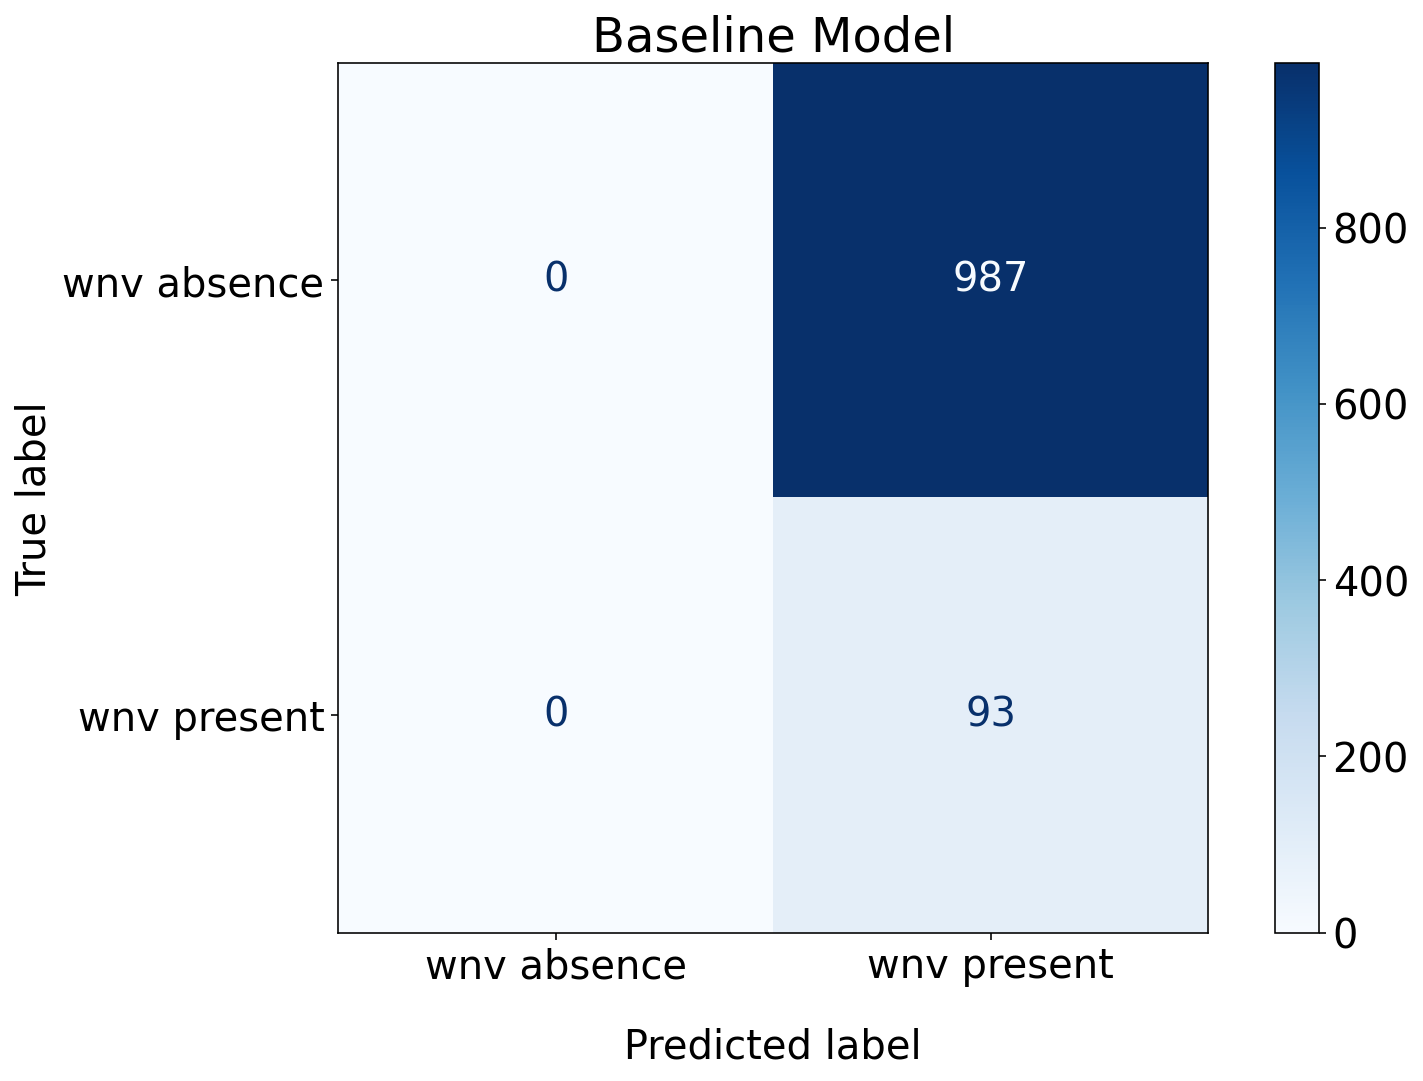

In [28]:
# derive tn, fp, tn, tp from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, baseline_pred, labels=[0,1]).ravel()

# get roc auc score
ras = roc_auc_score(y_test, np.ravel(baseline_pred))

model_name = 'ZeroR Classifier'

# print results
print(f'Model : {model_name}')
# print(f'Best CV {scorer} score : {model.best_score_*100:.1f}%')
# print(f'Train {scorer} score : {model.score(X_train, y_train)*100:.1f}%')
#print(f'Test score (accuracy) : {model.score(X_test, y_test)*100:.1f}%')
print(f'Sensitivity/Recall (true positive rate) : {tp/(tp+fn)*100:.1f}%')
#print(f'Specificity (true negative rate) : {tn/(tn+fp)*100:.1f}%')
print(f'Precision (positive predictive rate) : {tp/(tp+fp)*100:.1f}%')
print(f'Misclassification : {(1-((tp+tn)/(tp+tn+fp+fn)))*100:.1f}%')
# print(f'Test score (accuracy) : {model.score(X_test, y_test)*100:.1f}%')
print(f'F1-score : {2*tp/(2*tp+fp+fn)*100:.1f}%')
print(f'roc_auc score : {ras*100:.1f}%')

# plot confusion matrix
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, figsize=(12,8))
ConfusionMatrixDisplay.from_predictions(y_test, baseline_pred, 
                                      cmap = 'Blues', display_labels=('wnv absence', 'wnv present'),
                                     ax=ax)
plt.title('Baseline Model')
ax.xaxis.labelpad=20

### Defining function for different models

In [29]:
def modelling(chosen_model):
    
    # set the random state
    rs = 5
    random_state = rs
    
    # model names
    model_name = {'logreg': 'Logistic Regression',
                 'knn': 'K-Nearest Neighbours',
                 'mnb': 'Multinomial Naive Bayes',
                 'cnb': 'Complement Naive Bayes'}
    
    # types of model to be called
    model_dict = {'logreg': LogisticRegression(random_state=rs, solver='liblinear', max_iter=1000),
                 'knn': KNeighborsClassifier(),
                 'mnb': MultinomialNB(),
                 'cnb': ComplementNB()}
    
    # setting up the pipeline
    
    # SMOTE not required for Complement Naive Bayes
    if chosen_model == 'cnb':
        pipeline = imbPipeline(steps = [['mms', MinMaxScaler()],
                                        ['model', model_dict[chosen_model]]
                                        ])

    # SMOTE required for the rest
    else:   
        pipeline = imbPipeline(steps = [['smote', SMOTE(random_state=rs)],
                                        ['mms', MinMaxScaler()],
                                        ['model', model_dict[chosen_model]]
                                        ])

    # setting the folds to be stratified
    stratified_kfold = StratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=rs)

    # hyperparameters for tuning
    lr_params = {'model__C': [0.01, 0.1, 1, 100, 1000, 10000],
                'model__penalty': ['l1', 'l2']}
    knn_params = {'model__n_neighbors': [3, 5, 7, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]}
    mnb_params = {'model__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
    cnb_params = {'model__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

    # different params for different models
    params_dict = {'logreg': lr_params,
                 'knn': knn_params,
                 'mnb': mnb_params,
                 'cnb': cnb_params}
    
    # setting up gridsearch for modelling
    model = GridSearchCV(estimator = pipeline,
                          param_grid = params_dict[chosen_model],
                          scoring = 'recall',
                          #scoring = ['recall', 'precision'],
                          #refit = 'recall',
                          cv = stratified_kfold,
                          n_jobs=-1
                         )
    
    # model fitting
    model.fit(X_train, y_train)
    
    # best params
    print(f'{model_name[chosen_model]} best parameters : {model.best_params_}\n')
    
    # show the scores
    scores_pl(model, model_name[chosen_model]+', recall-optimized')
    
    # return model to variable for further scrutiny, i.e. coefficients for logreg
    return model

K-Nearest Neighbours best parameters : {'model__n_neighbors': 101}

Model : K-Nearest Neighbours, recall-optimized
Best CV Recall score : 83.5%
Train Recall score : 89.2%
Sensitivity/Recall (true positive rate) : 82.8%
Precision (positive predictive rate) : 16.8%
Misclassification : 36.9%
F1-score : 27.9%
roc_auc score : 72.0%


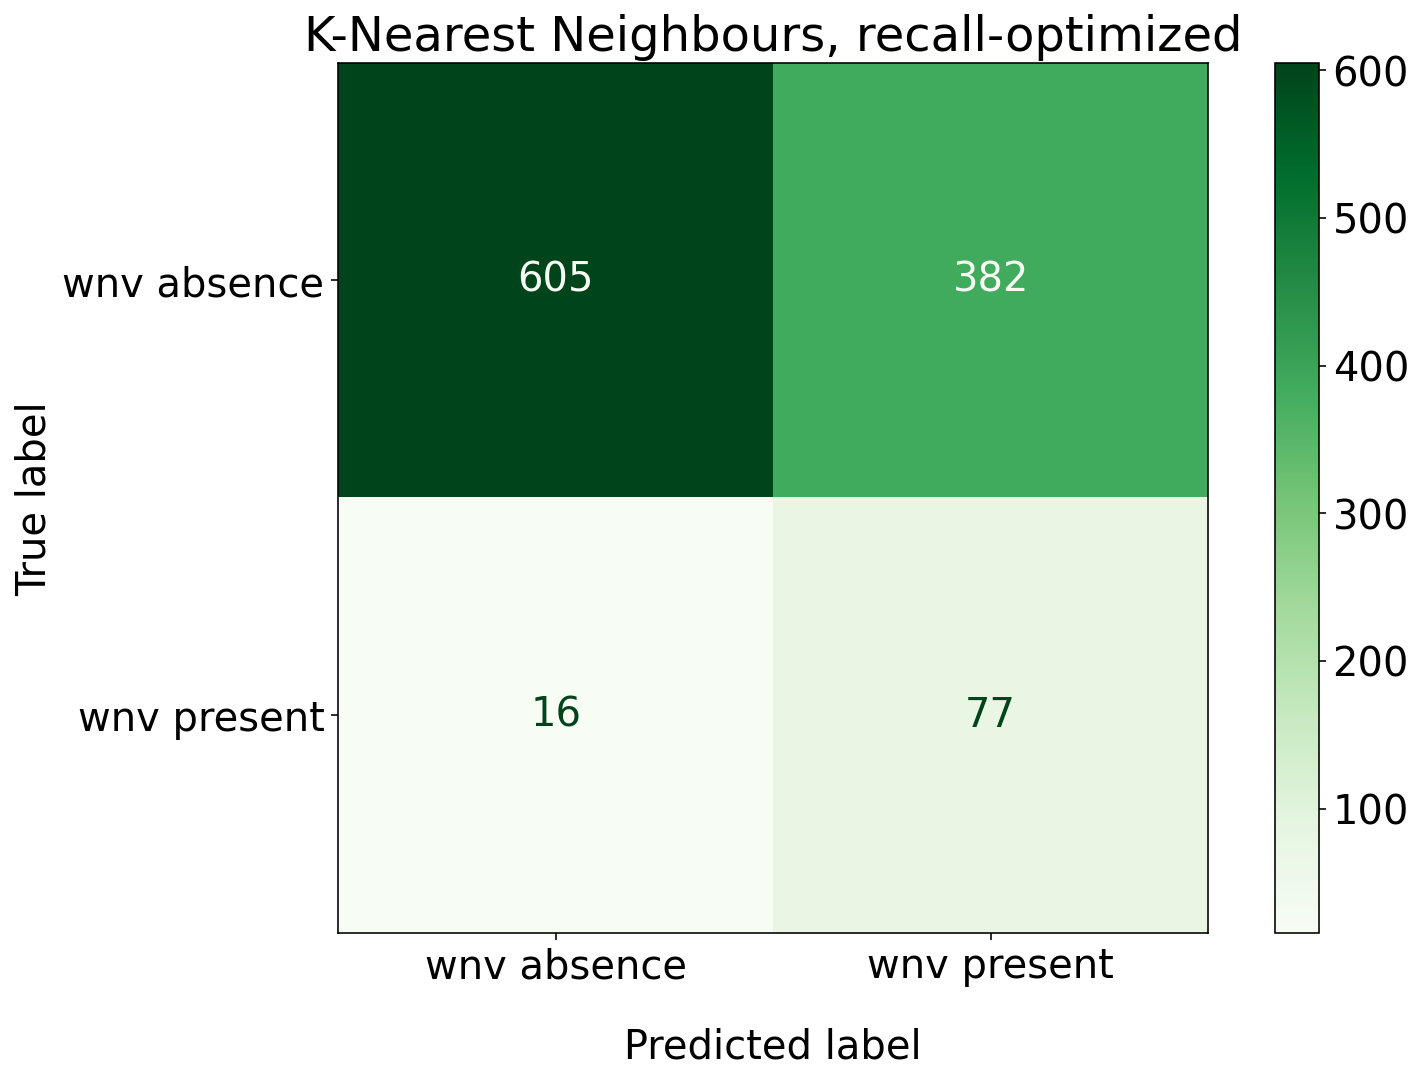

In [30]:
knn = modelling('knn')

Complement Naive Bayes best parameters : {'model__alpha': 0.1}

Model : Complement Naive Bayes, recall-optimized
Best CV Recall score : 80.7%
Train Recall score : 81.7%
Sensitivity/Recall (true positive rate) : 79.6%
Precision (positive predictive rate) : 14.0%
Misclassification : 43.8%
F1-score : 23.8%
roc_auc score : 66.8%


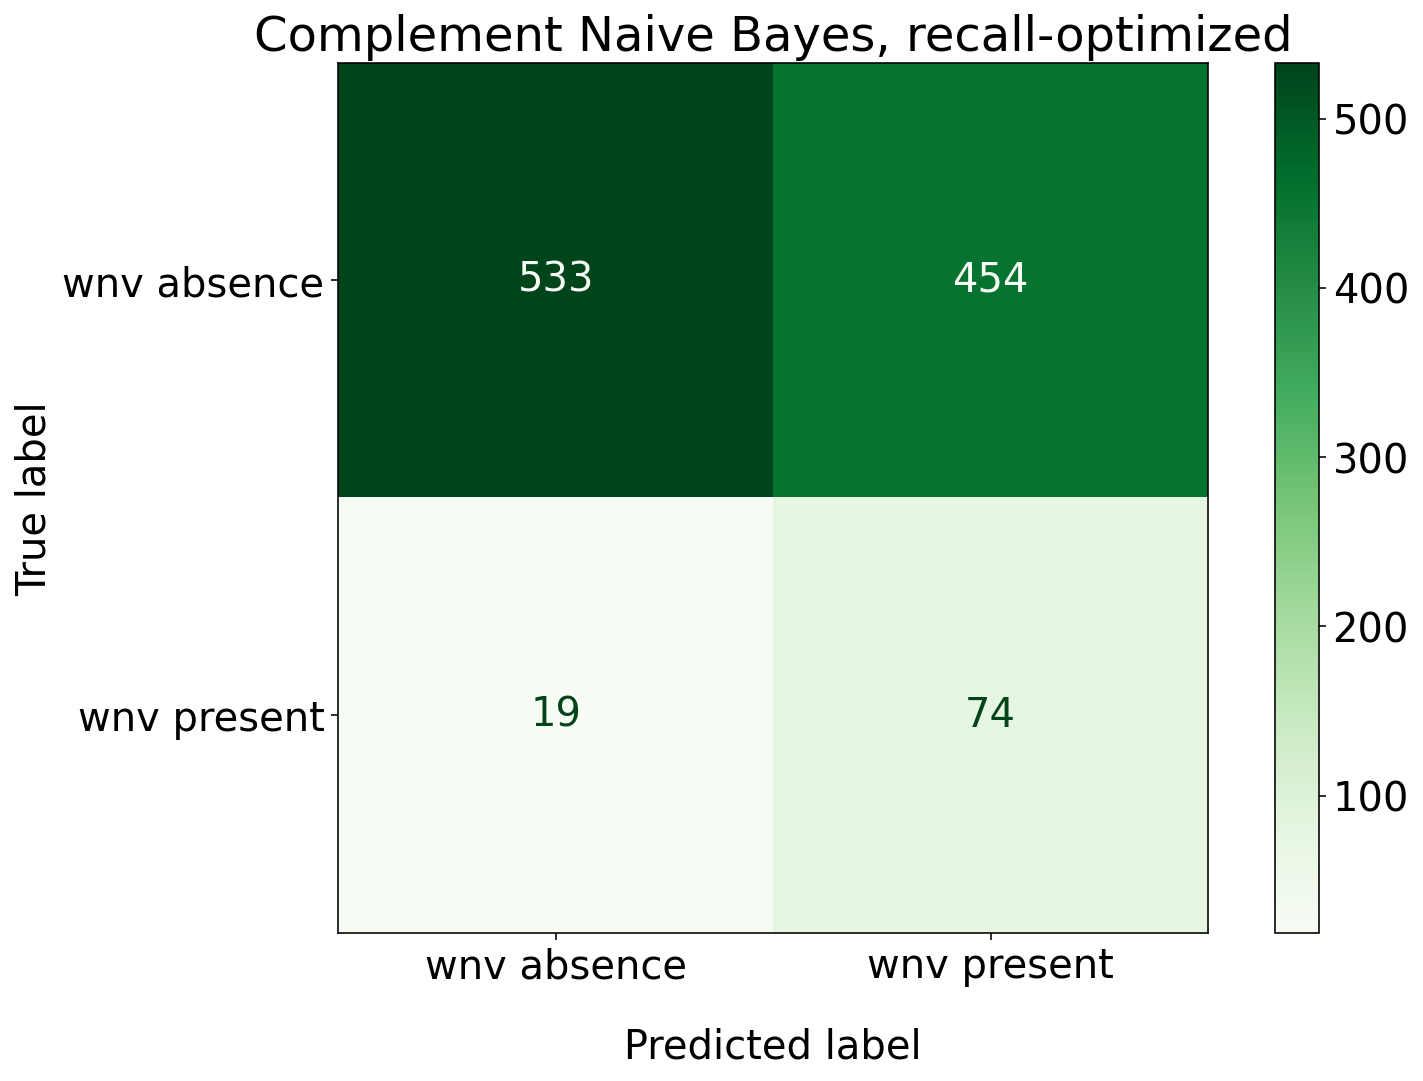

In [31]:
cnb = modelling('cnb')

Multinomial Naive Bayes best parameters : {'model__alpha': 0.1}

Model : Multinomial Naive Bayes, recall-optimized
Best CV Recall score : 83.5%
Train Recall score : 84.9%
Sensitivity/Recall (true positive rate) : 79.6%
Precision (positive predictive rate) : 13.6%
Misclassification : 45.5%
F1-score : 23.2%
roc_auc score : 65.9%


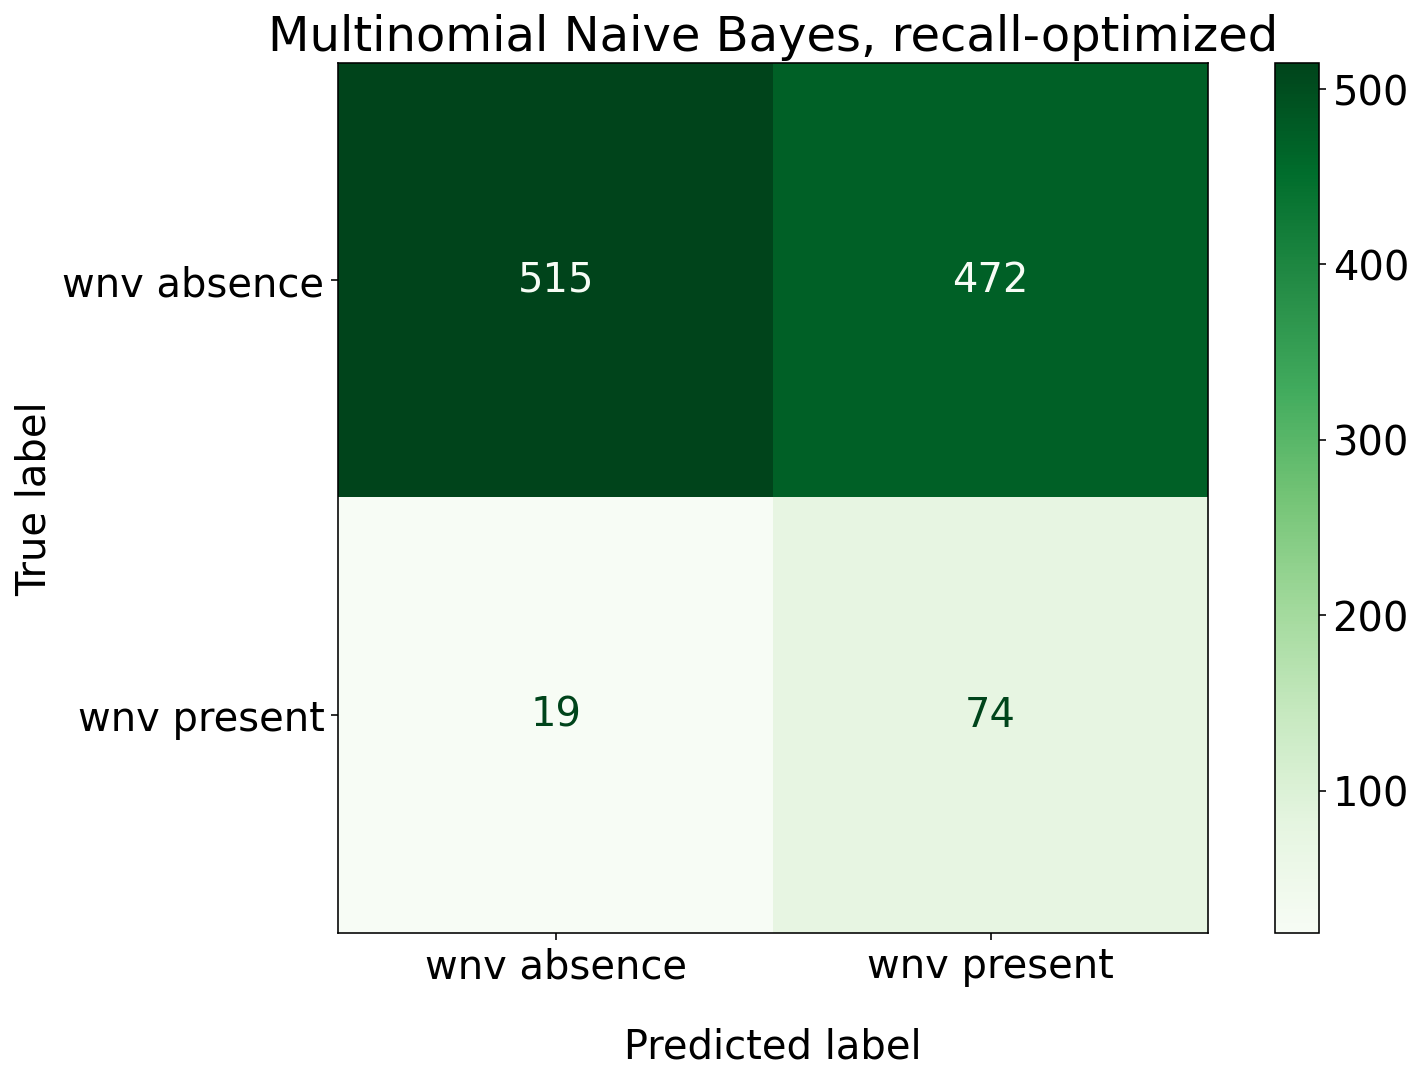

In [32]:
mnb = modelling('mnb')

Logistic Regression best parameters : {'model__C': 1, 'model__penalty': 'l1'}

Model : Logistic Regression, recall-optimized
Best CV Recall score : 77.4%
Train Recall score : 82.1%
Sensitivity/Recall (true positive rate) : 73.1%
Precision (positive predictive rate) : 15.6%
Misclassification : 36.4%
F1-score : 25.7%
roc_auc score : 67.9%


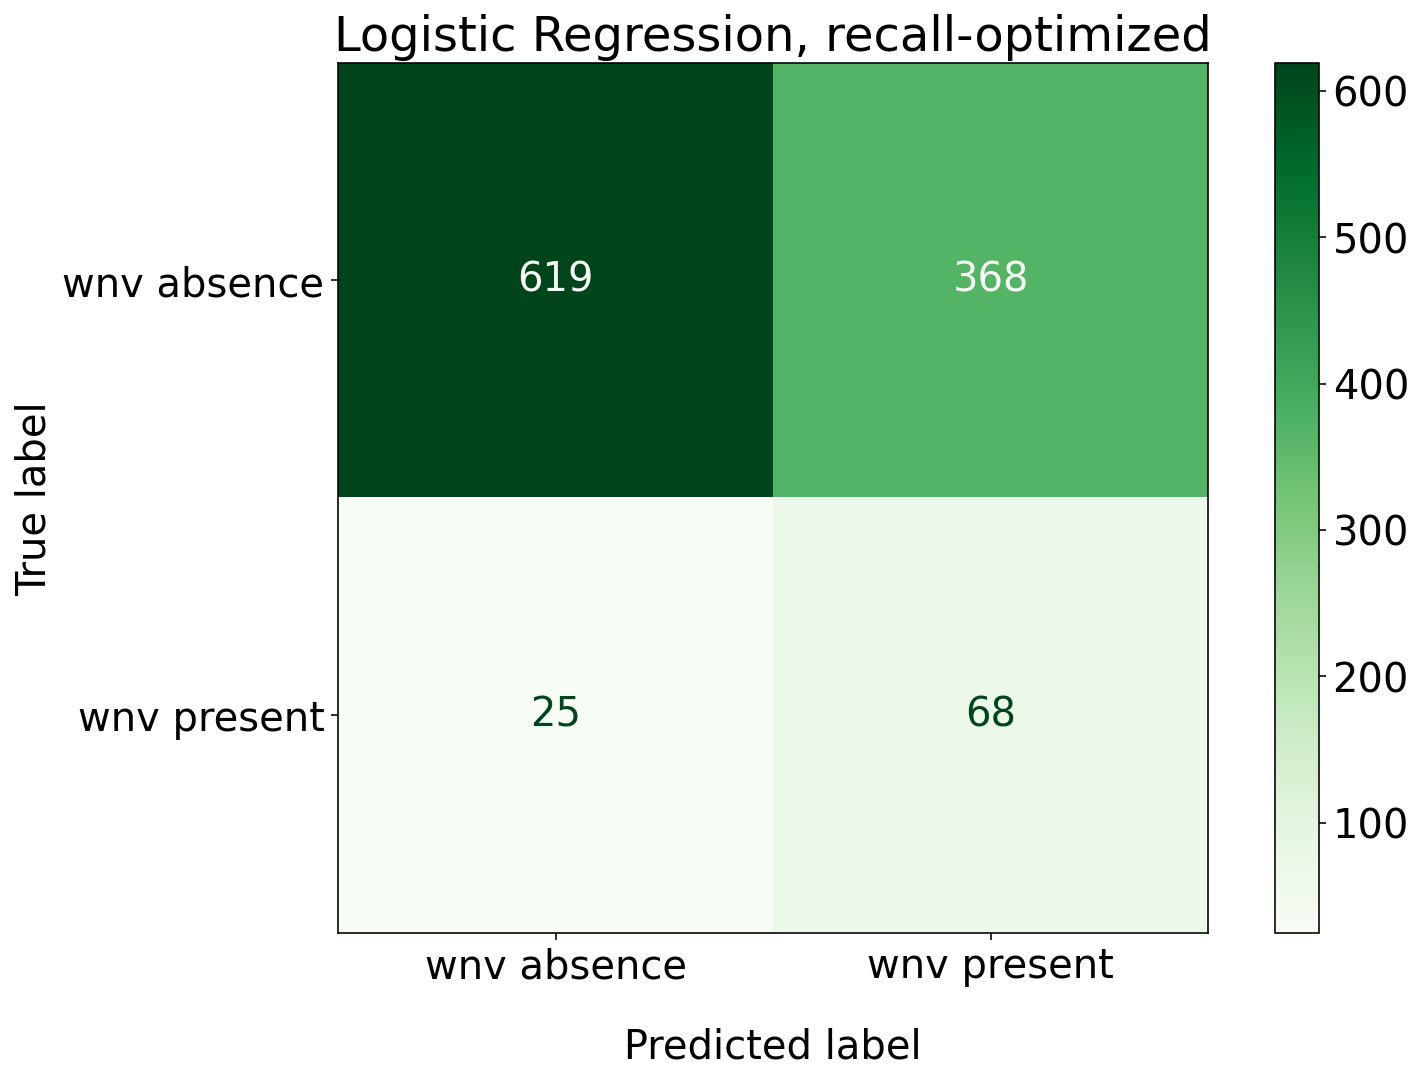

In [33]:
logreg = modelling('logreg')

### Setup for alternative model runs now.

In [34]:
### Set up for alternative model runs


In [35]:
#instantiate PCA
pca = PCA()

# set our CV parameters
stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=42)

##### Our original gridsearch parameters for the SVM model pipeline are as below. For brevity, we only run the pipeline with the best parameters identified by the gridsearchCV in the initial run.

For SVM:

param_svm = {

    'SVM__C':[0.001,0.1,10,100],
    
    'SVM__gamma':[0.1,0.01]
    
}

For Random Forest:

param_rf = { 

    'rf__n_estimators': [100, 200, 300],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [3, 5],
    'rf__max_depth': [10,15,20,30],
}


For Decision Trees:

param_df = { 

    'df__max_leaf_nodes': list(range(2, 100)),
    'df__min_samples_leaf': [3, 5],
    'df__max_depth': [2,4,6,8,10,15,20],
    'df__criterion' :['gini', 'entropy']
}

In [36]:
### Define different steps for our different models.


#define steps for SVM
steps_svm = [('smote', SMOTE(sampling_strategy='minority')), 
         ('under', RandomUnderSampler(sampling_strategy='majority')), 
         ('scaler', MinMaxScaler()), 
         ("pca", pca), 
         ('SVM', SVC(kernel='rbf', probability=True))]

#define best identified gridsearch parameters for SVM

param_svm = {
    'SVM__C':[0.001],
    'SVM__gamma':[0.01]
}

pipe_svm = imbPipeline(steps_svm)

In [37]:
### Define different steps for our different models.


#define steps for random forest
steps_rf = [('smote', SMOTE(sampling_strategy='minority')), 
         ('under', RandomUnderSampler(sampling_strategy='majority')), 
         ('scaler', MinMaxScaler()), 
         ("pca", pca), 
         ('rf', RandomForestClassifier())
            ]

#define best identified gridsearch parameters for random forest

param_rf = { 
    'rf__n_estimators': [200],
    'rf__min_samples_split': [3],
    'rf__min_samples_leaf': [3],
    'rf__max_depth': [10],
}

pipe_rf = imbPipeline(steps_rf)

In [38]:
### Define different steps for our different models.


#define steps for decision trees
steps_df = [('smote', SMOTE(sampling_strategy='minority')), 
#         ('under', RandomUnderSampler(sampling_strategy='majority')), 
         ('scaler', MinMaxScaler()), 
#         ("pca", pca), 
         ('df', DecisionTreeClassifier())
            ]

#define best identified gridsearch parameters for decision trees

param_df = { 
    'df__max_leaf_nodes': [2],
    'df__min_samples_leaf': [3],
    'df__max_depth': [2],
    'df__criterion' :['entropy']
}

pipe_df = imbPipeline(steps_df)

##### Now we start running our pipelines for SVM, RF and Decision trees as specified above. Our primary scoring metric will be Recall, or the True Positive Rate.

In [39]:
### Grid for SVM

grid_svm = GridSearchCV(pipe_svm,
                     param_grid=param_svm,
                     scoring='recall',
                     cv=stratified_kfold,
                     n_jobs=-1)

In [40]:
grid_svm.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(sampling_strategy='minority')),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy='majority')),
                                       ('scaler', MinMaxScaler()),
                                       ('pca', PCA()),
                                       ('SVM', SVC(probability=True))]),
             n_jobs=-1, param_grid={'SVM__C': [0.001], 'SVM__gamma': [0.01]},
             scoring='recall')

In [41]:
### Grid for SVM

cv_score = grid_svm.best_score_
test_score = grid_svm.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.971038961038961
Test score: 0.989247311827957


Best Score (Recall):                       97.1%
Train Score (Recall):                      98.9%
Accuracy (Test):                           35.199999999999996%
Misclassification:                         64.8%
Sensitivity / True Positive Rate / Recall: 98.9%
Specificity / True Negative Rate:          29.2%
Precision / Positive Predictive Value:     11.600000000000001%
F1 Score:                                  20.8%
ROC AUC Score:                             64.1%
Best Parameters:                           {'SVM__C': 0.001, 'SVM__gamma': 0.01}


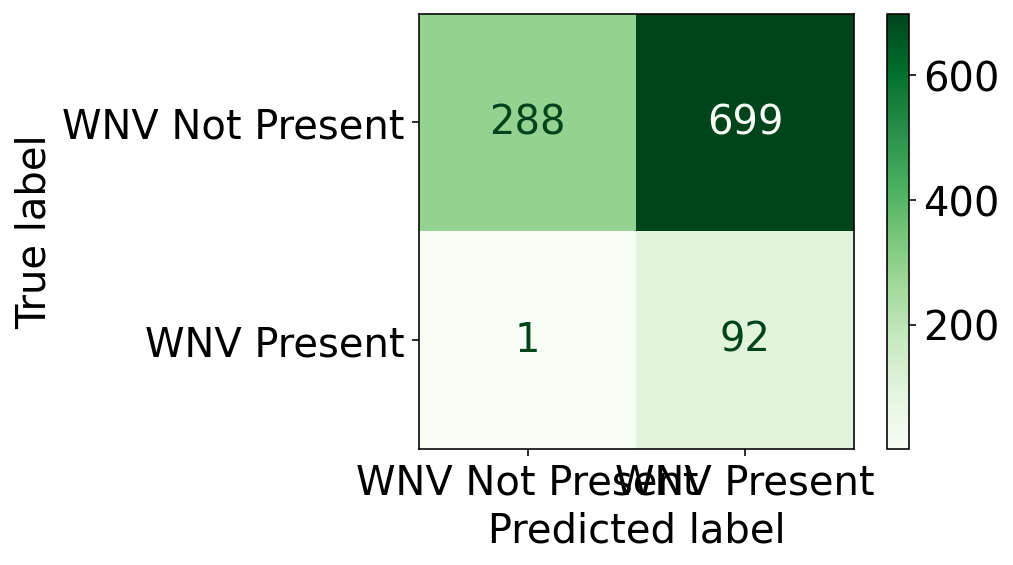

In [42]:
# Run predictions using the fitted SVM model on our test data-set.
# We review the accuracy metrics as well as the Confusion Matrix for the predictions.

model_preds_svm = grid_svm.predict(X_test)
model_results(model_preds_svm, X_train, y_train, X_test, y_test, grid_svm)

In [43]:
### Grid for RF

grid_rf = GridSearchCV(pipe_rf,
                     param_grid=param_rf,
                     scoring='recall',
                     cv=stratified_kfold,
                     n_jobs=-1)

In [44]:
grid_rf.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(sampling_strategy='minority')),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy='majority')),
                                       ('scaler', MinMaxScaler()),
                                       ('pca', PCA()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10], 'rf__min_samples_leaf': [3],
                         'rf__min_samples_split': [3],
                         'rf__n_estimators': [200]},
             scoring='recall')

In [45]:
### CV Scores for RF

cv_score = grid_rf.best_score_
test_score = grid_rf.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.6089610389610389
Test score: 0.7096774193548387


Best Score (Recall):                       60.9%
Train Score (Recall):                      93.5%
Accuracy (Test):                           75.4%
Misclassification:                         24.6%
Sensitivity / True Positive Rate / Recall: 71.0%
Specificity / True Negative Rate:          75.8%
Precision / Positive Predictive Value:     21.6%
F1 Score:                                  33.2%
ROC AUC Score:                             73.4%
Best Parameters:                           {'rf__max_depth': 10, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 3, 'rf__n_estimators': 200}


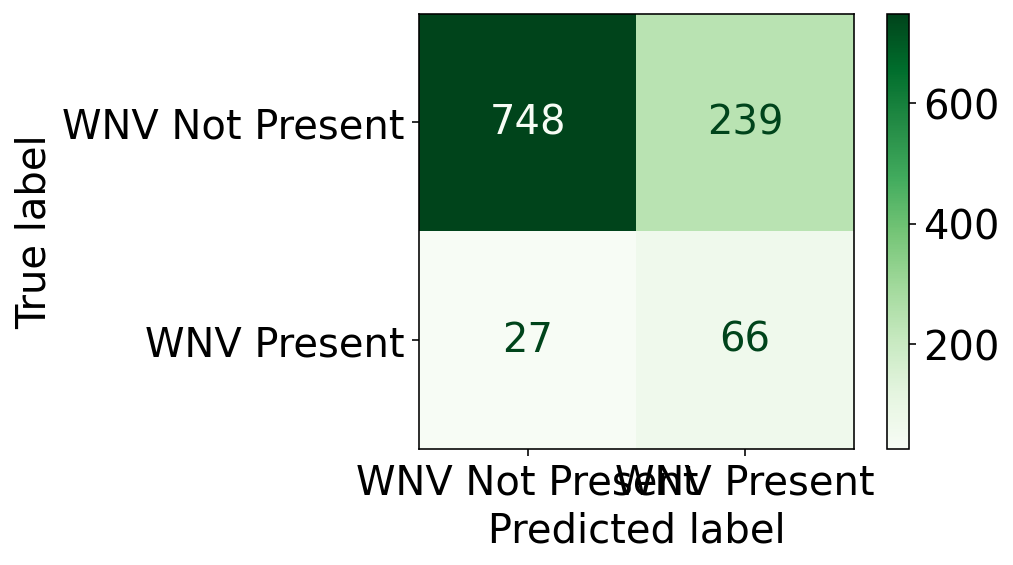

In [46]:
# Run predictions using the fitted Random Forest model on our test data-set.
# We review the accuracy metrics as well as the Confusion Matrix for the predictions.

model_preds_rf = grid_rf.predict(X_test)
model_results(model_preds_rf, X_train, y_train, X_test, y_test, grid_rf)

In [47]:
### Grid for Decision trees

grid_df = GridSearchCV(pipe_df,
                     param_grid=param_df,
                     scoring='recall',
                     cv=stratified_kfold,
                     n_jobs=-1)

In [48]:
grid_df.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(sampling_strategy='minority')),
                                       ('scaler', MinMaxScaler()),
                                       ('df', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'df__criterion': ['entropy'], 'df__max_depth': [2],
                         'df__max_leaf_nodes': [2],
                         'df__min_samples_leaf': [3]},
             scoring='recall')

In [49]:
### CV Scores for Decision Trees

cv_score = grid_df.best_score_
test_score = grid_df.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.9785064935064934
Test score: 0.967741935483871


Best Score (Recall):                       97.89999999999999%
Train Score (Recall):                      98.6%
Accuracy (Test):                           35.5%
Misclassification:                         64.5%
Sensitivity / True Positive Rate / Recall: 96.8%
Specificity / True Negative Rate:          29.7%
Precision / Positive Predictive Value:     11.5%
F1 Score:                                  20.5%
ROC AUC Score:                             63.2%
Best Parameters:                           {'df__criterion': 'entropy', 'df__max_depth': 2, 'df__max_leaf_nodes': 2, 'df__min_samples_leaf': 3}


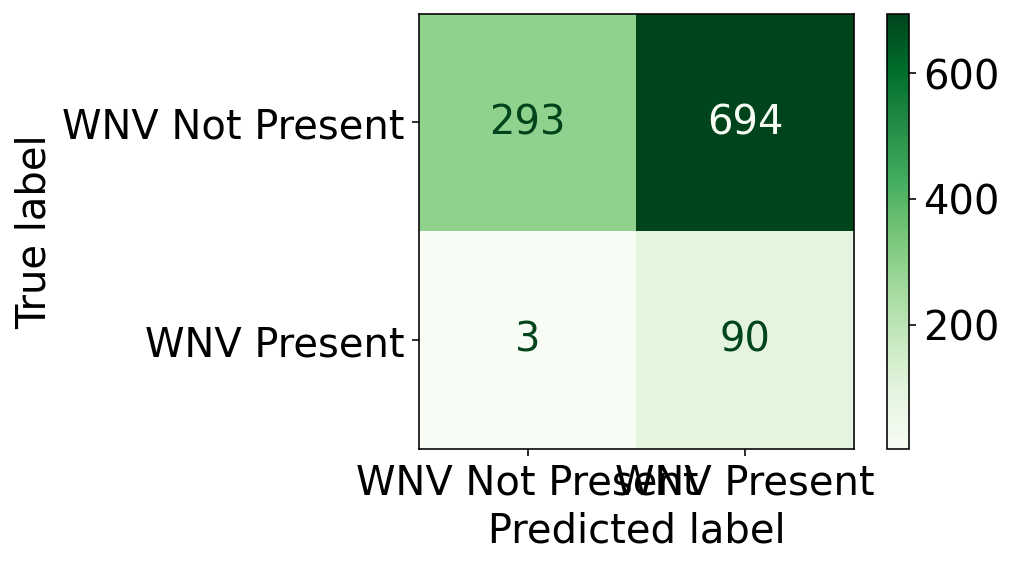

In [50]:
# Run predictions using the fitted Decision Tree model on our test data-set.
# We review the accuracy metrics as well as the Confusion Matrix for the predictions.

model_preds_df = grid_df.predict(X_test)
model_results(model_preds_df, X_train, y_train, X_test, y_test, grid_df)

### It appears that the Decision Tree is the best performing model if we wish to maximize the True Positive Rate, or recall.


1. However it appears that the number of false positives are now also significantly higher compared to the other models.


2. There seems to a diminishing returns effect for the trade-off between Recall and Specificity/Precision. 



#### Logistic Regression coefficients analysis

In [51]:
coef = np.ravel(logreg.best_estimator_['model'].coef_)
df = pd.DataFrame(zip(X_train.columns, coef), columns = ['feature', 'coef'])

#### Features that have no influence

In [52]:
df[df['coef']==0]

,feature,coef


#### Top positively associated features

In [53]:
df[df['coef']>0].sort_values(by='coef', ascending=False)

,feature,coef
0,week,4.192211
13,wetbulb3,1.598487
3,wetbulb,1.446432
17,avgspeed3,1.391339
12,rel_humidity2,0.613247
5,preciptotal,0.455851
15,cool3,0.288273
8,preciptotal_sum,0.132495


#### Top 10 negatively associated features

In [54]:
df.sort_values(by='coef', ascending=True).head(10)

,feature,coef
14,heat3,-6.144221
9,heat2,-5.061371
2,longitude,-1.804718
11,avgspeed2,-1.313873
4,heat,-1.293577
6,avgspeed,-0.767634
10,cool2,-0.705667
1,latitude,-0.609098
18,preciptotal_sum3,-0.462040
16,preciptotal3,-0.136527


#### Logistic Regression Coefficients Analysis

There were 7 features that are positively associated with the presence of west nile virus.

The top feature was 'week' of the year, which made a lot of sense and it is likely that the peak summer weeks are closely associated with the presence of west nile virus. There is however, a caveat as the data in the training set have been streamlined such that only the summer weeks were used for model training. There could be a prediction issue for weeks that were not used for model training, i.e. from Oct to Apr and this needs to be noted when using the model for prediction.

Two wetbulb features came up tops as well. One is the wetbulb temperature for the week in question, while another is the wetbulb temperature for 3 weeks back. The wetbulb temperature for the actual week could have a relationship with mosquito activity while the 3 weeks lag wetbulb temperature could be associated with the mosquito breeding activity.

Interestingly, the preciptotal or the average weekly rainfall for the week also had positive relationship with the presence of west nile virus. It is unclear how this relationship works. Could this be related with the mosquito activity similar to the wetbulb temperature in that there is higher mosquito activity when the weather is wet and perhaps humid too?

On the other hand, the top features that were negatively associated with the presence of west nile virus was heat ranging from the actual weeks to 2 and 3 weeks back. Heat is defined as (t_threshold - t_avg) if t_avg < 65, else 0. In other words, it relates to the required heating up to threshold temperature and is associated with cooler temperatures below the threshold. Hence, it is not surprising that this has a negative relationship with the presence of west nile virus since the requirement for heating would indicate a cooler weather which is less conducive for mosquito breeding and activity.

What is also interesting is that the cool or cooling requirement for 2 weeks back also showed up negative. Superficially, it might suggest that there could be an optimal temperature for mosquito breeding and activity. In other words, if the cooling requirement is very high or that the weather is too hot, mosquito breeding and activity could be curtailed. This could have manifested in few ways, that hot weather is associated with low rainfall for mosquito breeding, or that hot weather encourages faster evaporation and reduced wet spots for mosquito breeding. This may be an interesting insight.

Longitude also came up as negatively associated with west nile virus. In this particular example, the 'greater' values of longitude are areas that are closer to the coast. It seems to suggest that, locations nearer to the coast have lower propensity of seeing presence of west nile virus as compared to more inland. Could this relationship be due to more vegetation inland that provides more breeding spots and opportunities for mosquitos? This needs to be studied further.

## Model results summary

The different models tried produced varying results on both ends of the spectrum.

By and large, most models were able to generalize to unseen data, with relatively close train and test recall scores. There were two exceptions for Logistic Regression and Random Forest where the train and test variance were 10% and 20% respectively. These models were likely to be overfitted.

There were models with very strong performance with recall of 98.9% and 96.8%, namely SVM and decision trees; but these also had a high false positive and misclassification rate, resulting in poor precision scores of ~ 11.5%.

There were also more balanced models such as KNN, Multinomial Naive Bayes and Random Forest which had recall rates of ~80%, and better precision scores from 21% to 17%. 

| Model                | Best Cross Val (Recall)| Train Recall| Test Recall| Test Precision| Test F1-Score| ROC AUC | Misclassification |
|:---------------------|:-------:|:-----------:|:----------:|:-------------:|:------------:|:-------:|:----------:|
|Logistic Regression   |   77.4% |       82.1% |      73.1% |         15.6% |        25.7% |   67.9% |      36.4% |
|K-Nearest Neighbours  |   83.5% |       89.2% |      82.8% |         16.8% |        27.9% |   72.0% |      36.9% |
|Multinomial Naive Bayes|  83.5% |       84.9% |      79.6% |         13.6% |        23.2% |   65.9% |      45.5% |
|Complement Naive Bayes|   80.7% |       81.7% |      79.6% |         14.0% |        23.8% |   66.8% |      43.8% |
|Support Vector Machines  |   98.9% |       98.9% |      98.9% |         11.6% |        20.8% |   64.1% |      64.7% |
|Random Forest|  63.4% |       93.2% |      71.0% |         21.0% |        32.4% |   72.9% |      25.6% |
|Decision Trees|   96.4% |       98.6% |      96.8% |         11.5% |        20.5% |   63.2% |      64.5% |
   
The key metric of interest has been decided primarily on recall while precision score was also considered.
Inherently, due to the class imbalances where the minority class being only ~6% of all the data, precision score is highly susceptible to the skew by the majority class and is naturally on the low end. The benchmark for precision score should be more than 6%.

The rationale is that recall reflects how well the model is able to predict the presence of west nile virus correctly, in other words, we could be more certain that the model is not missing out true occurrences of west nile virus.

At the same time, the precision score is also important because we want to minimize any false alarms from the model. Unfortunately, the precision modelling is not good. This means that there is a high chance that the model is 'crying wolf'. In doing, so, this could result in excessive action taken to combat the west nile virus.

These are the trade offs to be considered and weighed. We want the model not to miss out any real events of west nile virus spreading but in doing so, it becomes overly conservative and produces significant amount of false alarms.\
As with the adage 'better be safe than sorry', it is better to be conservative in the prediction of west nile virus occurrences. To this end, it would likely mean that we might spend more resources on combating mosquitos.

From wikipedia,

>West Nile fever is an infection by the West Nile virus, which is typically spread by mosquitoes. In about 80% of infections people have few or no symptoms. About 20% of people develop a fever, headache, vomiting, or a rash. In less than 1% of people, encephalitis or meningitis occurs, with associated neck stiffness, confusion, or seizures. Recovery may take weeks to months. The risk of death among those in whom the nervous system is affected is about 10 percent.

Assuming by <1% is 0.5%. For every population of ~1 million infections, about 5 thousand folks will be adversely affected. The cost of hospitalization and the loss of lives surely would be able to justify the conservatism in model prediction. The main metric is then the recall score, i.e. we want to sure that the model is not missing out any real cases whenever the model says there is likelihood of west nile virus presence. The only question is, what is the infection rate for west nile virus?

## Conclusion

From existing train data, we made an attempt to draw some parallels with reported adverse infection cases published by the CDC to establish a link between the occurrences of west nile virus to the cases of adverse viral infections.

Given the lack granularity in the data, we had to assume that the mosquitos traps data were collected across the different years in a consistent and structured manner, i.e. traps location are same across different years, frequency of checks on traps were consistent across different years. With that, we were able to come up with a simple relationship between the available data on the presence of west nile virus with the adverse infections cases.

| year | wnv present counts | adverse infections cases | adverse infections to wnv present hit rate (%) |
|:----:|:------------------:|:------------------------:|:----------------------------------------------:|
| 2007 |        143         |           25             |                        17%                     |
| 2009 |         17         |            2             |                        12%                     |
| 2011 |         43         |            9             |                        21%                     |
| 2013 |        169         |           35             |                        21%                     |  

Therefore, we estimated the the hit rate for adverse west nile virus infections based on the occurrences of west nile virus from our model is around 20%.

The next question is, could we use the model predictions on the number of west nile virus occurrences to translate into the estimated infection cases? From of the understanding that the model is not perfect based on the recall and precision scores, we know as a matter of fact that there is some bias between the model predictions and reality.

To this end, since we know the chosen model precision scores is about 17%, it means that of all the model predictions, it is likely that only 17% accounts for the true west nile virus occurrences. In the same vein, we know that the recall score of 83% meant that the model would capture only 83% of true occurrences. Therefore, model positive west nile virus predictions * 17% = true positive / 83% = true west nile virus occurrences. In other words, the true west nile virus occurrences is about 20% of the model positive west nile virus predictions.

Using this empirical relationship, we can then establish that the estimated adverse infections rate is ~4% (20% true wnv occurrences out of model predictions x 20% adverse infection cases out of true wnv occurrences). Thus, for every 1000 wnv occurrences predicted by the model, we estimate that there could be 40 adverse west nile viral infection cases. Armed with this information, we could then esablish if it would be worthwhile deploying city wide spraying through a cost-benefit analysis.

## Predicting unseen test data

### Import data file

In [55]:
test = pd.read_csv('../assets/test1.csv')

### Display columns of interest

In [56]:
X_train.columns

Index(['week', 'latitude', 'longitude', 'wetbulb', 'heat', 'preciptotal',
       'avgspeed', 'rel_humidity', 'preciptotal_sum', 'heat2', 'cool2',
       'avgspeed2', 'rel_humidity2', 'wetbulb3', 'heat3', 'cool3',
       'preciptotal3', 'avgspeed3', 'preciptotal_sum3'],
      dtype='object')

### Filter unseen test columns for prediction

In [57]:
test.head()

,year,month,week,latitude,longitude,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,...,avgspeed3,rel_humidity3,VCTS_week3,FG_week3,TSRA_week3,RA_week3,DZ_week3,BR_week3,HZ_week3,preciptotal_sum3
0,2008,6,24,41.95469,-87.800991,0,1,0,0,0,...,9.3,56.409332,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.01
1,2008,6,24,41.95469,-87.800991,0,0,1,0,0,...,9.3,56.409332,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.01
2,2008,6,24,41.95469,-87.800991,1,0,0,0,0,...,9.3,56.409332,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.01
3,2008,6,24,41.95469,-87.800991,0,0,0,1,0,...,9.3,56.409332,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.01
4,2008,6,24,41.95469,-87.800991,0,0,0,0,0,...,9.3,56.409332,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.01


In [58]:
test.columns

Index(['year', 'month', 'week', 'latitude', 'longitude',
       'species_CULEX PIPIENS', 'species_CULEX PIPIENS/RESTUANS',
       'species_CULEX RESTUANS', 'species_CULEX SALINARIUS',
       'species_CULEX TARSALIS', 'species_CULEX TERRITANS',
       'species_UNSPECIFIED CULEX', 'station', 'long_lat', 'tavg', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure', 'resultdir',
       'avgspeed', 'rel_humidity', 'VCTS_week', 'FG_week', 'TSRA_week',
       'RA_week', 'DZ_week', 'BR_week', 'HZ_week', 'preciptotal_sum', 'tavg2',
       'dewpoint2', 'wetbulb2', 'heat2', 'cool2', 'preciptotal2',
       'stnpressure2', 'resultdir2', 'avgspeed2', 'rel_humidity2',
       'VCTS_week2', 'FG_week2', 'TSRA_week2', 'RA_week2', 'DZ_week2',
       'BR_week2', 'HZ_week2', 'preciptotal_sum2', 'tavg3', 'dewpoint3',
       'wetbulb3', 'heat3', 'cool3', 'preciptotal3', 'stnpressure3',
       'resultdir3', 'avgspeed3', 'rel_humidity3', 'VCTS_week3', 'FG_week3',
       'TSRA_week3', 'RA_w

In [59]:
test.drop(columns = ['species_UNSPECIFIED CULEX',
                    'species_CULEX PIPIENS', 'species_CULEX PIPIENS/RESTUANS',
                    'species_CULEX RESTUANS', 'species_CULEX SALINARIUS', 'species_CULEX TARSALIS',
                    'species_CULEX TERRITANS', 'station', 'stnpressure', 'resultdir', 'VCTS_week',
                    'FG_week', 'TSRA_week', 'RA_week', 'DZ_week', 'BR_week', 'HZ_week', 'VCTS_week2',
                    'FG_week2', 'TSRA_week2', 'RA_week2', 'DZ_week2', 'BR_week2', 'HZ_week2', 'VCTS_week3',
                    'FG_week3', 'TSRA_week3', 'RA_week3', 'DZ_week3', 'BR_week3', 'HZ_week3',
                    'stnpressure2', 'stnpressure3', 'resultdir2', 'resultdir3',
                    'tavg', 'tavg2', 'tavg3', 'dewpoint', 'dewpoint2', 'dewpoint3', 
                    'month', 'long_lat', 'cool', 'wetbulb2', 'preciptotal2',
                    'preciptotal_sum2', 'rel_humidity3'], inplace=True)

In [60]:
test.columns

Index(['year', 'week', 'latitude', 'longitude', 'wetbulb', 'heat',
       'preciptotal', 'avgspeed', 'rel_humidity', 'preciptotal_sum', 'heat2',
       'cool2', 'avgspeed2', 'rel_humidity2', 'wetbulb3', 'heat3', 'cool3',
       'preciptotal3', 'avgspeed3', 'preciptotal_sum3'],
      dtype='object')

In [61]:
test.head()

,year,week,latitude,longitude,wetbulb,heat,preciptotal,avgspeed,rel_humidity,preciptotal_sum,heat2,cool2,avgspeed2,rel_humidity2,wetbulb3,heat3,cool3,preciptotal3,avgspeed3,preciptotal_sum3
0,2008,24,41.95469,-87.800991,64.428571,0.0,0.102143,10.3,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01
1,2008,24,41.95469,-87.800991,64.428571,0.0,0.102143,10.3,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01
2,2008,24,41.95469,-87.800991,64.428571,0.0,0.102143,10.3,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01
3,2008,24,41.95469,-87.800991,64.428571,0.0,0.102143,10.3,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01
4,2008,24,41.95469,-87.800991,64.428571,0.0,0.102143,10.3,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01


### Drop duplicates for prediction analysis

The reason for dropping duplicates is that the test data breaks down each date and location into 8 different category for the mosquito species. For the purpose of predicting the infections, we need to ensure the dimensions (column features) of the test matches the model features. And in the training of the model, we had aggregated the species category into a single row. Therefore, for a representative prediction of the unseen test data, the data structure has to be in the same form as the model training structure.

In [62]:
test1 = test.drop_duplicates()
test1.shape

(9966, 20)

In [63]:
test1.head()

,year,week,latitude,longitude,wetbulb,heat,preciptotal,avgspeed,rel_humidity,preciptotal_sum,heat2,cool2,avgspeed2,rel_humidity2,wetbulb3,heat3,cool3,preciptotal3,avgspeed3,preciptotal_sum3
0,2008,24,41.954690,-87.800991,64.428571,0.0,0.102143,10.300000,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01
8,2008,24,41.994991,-87.769279,64.428571,0.0,0.102143,10.300000,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01
16,2008,24,41.974089,-87.824812,64.428571,0.0,0.102143,10.300000,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01
24,2008,24,41.921600,-87.666455,65.000000,0.0,0.100000,10.642857,61.105628,0.700,5.285714,1.714286,10.085714,60.196251,47.571429,9.285714,0.0,0.001429,9.2,0.01
32,2008,24,41.891118,-87.654491,65.000000,0.0,0.100000,10.642857,61.105628,0.700,5.285714,1.714286,10.085714,60.196251,47.571429,9.285714,0.0,0.001429,9.2,0.01


In [64]:
test1.groupby(['year','week','latitude']).mean()

longitude    wetbulb       heat  preciptotal   avgspeed  \
year week latitude                                                             
2008 24   41.644612 -87.604498  65.000000   0.000000        0.100  10.642857   
          41.646541 -87.543762  65.000000   0.000000        0.100  10.642857   
          41.659112 -87.538693  65.000000   0.000000        0.100  10.642857   
          41.662014 -87.724608  65.000000   0.000000        0.100  10.642857   
          41.673408 -87.599862  65.000000   0.000000        0.100  10.642857   
...                        ...        ...        ...          ...        ...   
2014 40   42.008314 -87.777921  50.857143  10.142857        0.155  10.885714   
          42.009876 -87.807277  50.857143  10.142857        0.155  10.885714   
          42.010412 -87.662140  50.857143  10.142857        0.155  10.885714   
          42.011601 -87.811506  50.857143  10.142857        0.155  10.885714   
          42.017430 -87.687769  50.857143  10.142857        0.155  10.885714   

                     rel_humidity  preciptotal_sum     heat2     cool2  \
year week latitude                                                       
2008 24   41.644612     61.105628            0.700  5.285714  1.714286   
          41.646541     61.105628            0.700  5.285714  1.714286   
          41.659112     61.105628            0.700  5.285714  1.714286   
          41.662014     61.105628            0.700  5.285714  1.714286   
          41.673408     61.105628            0.700  5.285714  1.714286   
...                           ...              ...       ...       ...   
2014 40   42.008314     71.602920            1.085  4.428571  0.857143   
          42.009876     71.602920            1.085  4.428571  0.857143   
          42.010412     71.602920            1.085  4.428571  0.857143   
          42.011601     71.602920            1.085  4.428571  0.857143   
          42.017430     71.602920            1.085  4.428571  0.857143   

                     avgspeed2  rel_humidity2   wetbulb3     heat3     cool3  \
year week latitude                                                             
2008 24   41.644612  10.085714      60.196251  47.571429  9.285714  0.000000   
          41.646541  10.085714      60.196251  47.571429  9.285714  0.000000   
          41.659112  10.085714      60.196251  47.571429  9.285714  0.000000   
          41.662014  10.085714      60.196251  47.571429  9.285714  0.000000   
          41.673408  10.085714      60.196251  47.571429  9.285714  0.000000   
...                        ...            ...        ...       ...       ...   
2014 40   42.008314   7.528571      65.364067  53.285714  7.571429  1.428571   
          42.009876   7.528571      65.364067  53.285714  7.571429  1.428571   
          42.010412   7.528571      65.364067  53.285714  7.571429  1.428571   
          42.011601   7.528571      65.364067  53.285714  7.571429  1.428571   
          42.017430   7.528571      65.364067  53.285714  7.571429  1.428571   

                     preciptotal3  avgspeed3  preciptotal_sum3  
year week latitude                                              
2008 24   41.644612      0.001429   9.200000              0.01  
          41.646541      0.001429   9.200000              0.01  
          41.659112      0.001429   9.200000              0.01  
          41.662014      0.001429   9.200000              0.01  
          41.673408      0.001429   9.200000              0.01  
...                           ...        ...               ...  
2014 40   42.008314      0.207143   9.271429              1.45  
          42.009876      0.207143   9.271429              1.45  
          42.010412      0.207143   9.271429              1.45  
          42.011601      0.207143   9.271429              1.45  
          42.017430      0.207143   9.271429              1.45  

[9966 rows x 17 columns]

In [65]:
test_X = test1.drop(columns='year')
test_X.head()

,week,latitude,longitude,wetbulb,heat,preciptotal,avgspeed,rel_humidity,preciptotal_sum,heat2,cool2,avgspeed2,rel_humidity2,wetbulb3,heat3,cool3,preciptotal3,avgspeed3,preciptotal_sum3
0,24,41.954690,-87.800991,64.428571,0.0,0.102143,10.300000,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01
8,24,41.994991,-87.769279,64.428571,0.0,0.102143,10.300000,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01
16,24,41.974089,-87.824812,64.428571,0.0,0.102143,10.300000,62.315522,0.715,6.142857,0.714286,10.242857,63.201701,47.285714,10.714286,0.0,0.001429,9.3,0.01
24,24,41.921600,-87.666455,65.000000,0.0,0.100000,10.642857,61.105628,0.700,5.285714,1.714286,10.085714,60.196251,47.571429,9.285714,0.0,0.001429,9.2,0.01
32,24,41.891118,-87.654491,65.000000,0.0,0.100000,10.642857,61.105628,0.700,5.285714,1.714286,10.085714,60.196251,47.571429,9.285714,0.0,0.001429,9.2,0.01


In [66]:
len(test_X.columns)==len(X_train.columns)

True

### Using KNN to predict

In [67]:
knn_preds = knn.predict(test_X)
preds = pd.DataFrame(zip(test1['year'], test1['week'],knn_preds,
                         test['latitude'], test['longitude']), 
                     columns=['year','week','wnvpresent','latitude','longitude'])
preds.head()

,year,week,wnvpresent,latitude,longitude
0,2008,24,0,41.95469,-87.800991
1,2008,24,0,41.95469,-87.800991
2,2008,24,0,41.95469,-87.800991
3,2008,24,0,41.95469,-87.800991
4,2008,24,0,41.95469,-87.800991


In [68]:
pd.pivot_table(preds, values='week', index=['year','wnvpresent'], aggfunc='count')

week
year wnvpresent      
2008 0           1329
     1           1087
2010 0           1510
     1           1057
2012 0           1471
     1            794
2014 0           1839
     1            879

In [69]:
pd.pivot_table(clean_data1, values='week', index=['year','wnvpresent'], aggfunc='count')

week
year wnvpresent      
2007 0           1276
     1            143
2009 0            816
     1             17
2011 0            807
     1             43
2013 0           1049
     1            169

### Prediction Analysis

In [70]:
clean_data1[clean_data1['year']==2013]['wnvpresent'].value_counts()

0    1049
1     169
Name: wnvpresent, dtype: int64

KNN model recap:\
recall score = 82.8%, precision score = 16.8%\
Assuming that model performance is similar for the unseen data and the training test dataset...


| year | model predicted occurrences | precision adjusted occurrences | recall adjusted occurrences | estimated wnv infections based on hit rate |  
|:----:|:-----------:|:-----------:|:-----------:|:-----------:|
| Example: |  (A)    |(B) = (A) × 16.8%|(C) = (B) ÷ 82.8%|(D) = (C) × 21%|  
| 2008 |     1087    |     183     |      221    |     46      |
| 2010 |     1056    |     177     |      213    |     45      |
| 2012 |      794    |     133     |      161    |     37      |
| 2014 |      879    |     148     |      179    |     38      |

Assumptions:\
2013 Chicago WNV infections (35) prorated based on 2013 reported Illinois WNV adverse infections (86).\
WNV infections hit rate is estimated to be 21% (35/169) based on the mapping of incidence of presence of west nile virus with the infection counts. This is by no means instructive but a mere anecdoctal representation in the absence of available data.

### Prediction by location

In [71]:
test_preds = pd.pivot_table(preds, values='wnvpresent', 
                            index=['year','wnvpresent','latitude','longitude'], aggfunc='count')
test_preds.head()

week
year wnvpresent latitude  longitude       
2008 0          41.644612 -87.604498     1
                41.646541 -87.543762    12
                41.659112 -87.538693     8
                41.662014 -87.724608     8
                41.673408 -87.599862     7

In [72]:
test_preds['year'] = test_preds.index.get_level_values('year')
test_preds['wnvpresent'] = test_preds.index.get_level_values('wnvpresent')
test_preds['latitude'] = test_preds.index.get_level_values('latitude')
test_preds['longitude'] = test_preds.index.get_level_values('longitude')
test_preds.reset_index(inplace=True, drop=True)
test_preds

,week,year,wnvpresent,latitude,longitude
0,1,2008,0,41.644612,-87.604498
1,12,2008,0,41.646541,-87.543762
2,8,2008,0,41.659112,-87.538693
3,8,2008,0,41.662014,-87.724608
4,7,2008,0,41.673408,-87.599862
...,...,...,...,...,...
1131,2,2014,1,41.999129,-87.795585
1132,4,2014,1,42.006858,-87.675919
1133,8,2014,1,42.008314,-87.777921
1134,2,2014,1,42.009876,-87.807277


In [73]:
df_y_present = test_preds[test_preds['wnvpresent']==1]
df_y_present.to_csv('../assets/wnvpresent_loc.csv', index=False)
df_y_present.head()

,week,year,wnvpresent,latitude,longitude
148,15,2008,1,41.644612,-87.604498
149,4,2008,1,41.646541,-87.543762
150,8,2008,1,41.659112,-87.538693
151,8,2008,1,41.662014,-87.724608
152,9,2008,1,41.673408,-87.599862


In [74]:
df_2008 = df_y_present[df_y_present['year']==2008].sort_values(by='week', ascending=False)
df_2008[df_2008['week']>10]

,week,year,wnvpresent,latitude,longitude
185,16,2008,1,41.753411,-87.639817
235,16,2008,1,41.904194,-87.756155
239,16,2008,1,41.912563,-87.668055
257,15,2008,1,41.951866,-87.725057
165,15,2008,1,41.719140,-87.669539
189,15,2008,1,41.763733,-87.742302
280,15,2008,1,41.987280,-87.666066
148,15,2008,1,41.644612,-87.604498
270,15,2008,1,41.965571,-87.781978
195,14,2008,1,41.775051,-87.655356


In [75]:
df_y_present[df_y_present['year']==2010].sort_values(by='week', ascending=False)

,week,year,wnvpresent,latitude,longitude
566,16,2010,1,41.974689,-87.890615
473,15,2010,1,41.737052,-87.543067
532,13,2010,1,41.911824,-87.726737
562,13,2010,1,41.966987,-87.674677
545,13,2010,1,41.940160,-87.794896
...,...,...,...,...,...
480,1,2010,1,41.753391,-87.707394
533,1,2010,1,41.912563,-87.668055
459,1,2010,1,41.704572,-87.565666
454,1,2010,1,41.688324,-87.676709


In [76]:
df_y_present[df_y_present['year']==2012].sort_values(by='week', ascending=False)

,week,year,wnvpresent,latitude,longitude
762,13,2012,1,41.737052,-87.543067
769,11,2012,1,41.753391,-87.707394
764,11,2012,1,41.738903,-87.695443
853,10,2012,1,41.965571,-87.781978
770,10,2012,1,41.753411,-87.639817
...,...,...,...,...,...
805,1,2012,1,41.857402,-87.694991
788,1,2012,1,41.794781,-87.615989
759,1,2012,1,41.731922,-87.677512
755,1,2012,1,41.725517,-87.614258


In [77]:
df_y_present[df_y_present['year']==2014].sort_values(by='week', ascending=False)

,week,year,wnvpresent,latitude,longitude
1043,16,2014,1,41.737052,-87.543067
1031,16,2014,1,41.704572,-87.565666
1071,16,2014,1,41.798697,-87.736812
1048,16,2014,1,41.747850,-87.702716
1026,16,2014,1,41.686398,-87.531635
...,...,...,...,...,...
1064,1,2014,1,41.777689,-87.749149
1025,1,2014,1,41.682587,-87.707973
1039,1,2014,1,41.731922,-87.677512
1041,1,2014,1,41.732984,-87.649642


### Predictions for Kaggle submission

In [78]:
test_X_kag = test.drop(columns='year')
test_y_kag = pd.DataFrame(knn.predict(test_X_kag), columns=['wnvpresent'])

In [79]:
test_y_kag.to_csv('../assets/submission.csv', index=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ebea3184-33fc-459d-b891-b6437e522278' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>